In [1]:
import os
import numpy as np
from PIL import Image, ImageFile
from skimage import io
import matplotlib.pyplot as plt
import tifffile
from scipy import misc
from tifffile import TiffFile
from tifffile.tifffile import TIFF_DECOMPESSORS
from visualization import ids_to_greyscale, load_depth, show_bounding_boxes, load_stencil_ids, load_stencil_flags

In [2]:
import visualization
visualization.multi_page = False
visualization.ini_file = 'gta-postprocessing.local.ini'

scene_condition = """
    ( \
        SELECT scene_id \
        FROM snapshots \
        WHERE run_id = 6 \
        ORDER BY timestamp DESC \
        OFFSET 80 \
        LIMIT 1 \
    ) \
    """

scene_condition = """
    'aee42a64-cd1b-4b91-ad0e-1af0ce9e9cde' \
    """

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, cam_near_clip, cam_far_clip, 
    ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as relative_cam_rot \
    FROM snapshots \
    WHERE scene_id = {} \
    """.format(scene_condition))

results = [dict(res) for res in cur]
names = [i['imagepath'] for i in results]
print(names[0])

2018-02-17--19-42-58--377


### obtaining detections for this scene

In [11]:
detections = {}
for res in results:
    cur.execute("""SELECT detection_id, type, class, bbox, \
        snapshot_id, handle, ARRAY[st_x(pos), st_y(pos), st_z(pos)] AS pos \
        FROM detections \
        WHERE snapshot_id = {} \
        AND type = 'car' \
        AND NOT bbox @> point '(Infinity, Infinity)' \
        """.format(res['snapshot_id']))
    detections[res['snapshot_id']] = [dict(i) for i in cur]


In [12]:
for res in results:  
    print('detections for image {}:'.format(res['snapshot_id']))
    for det in detections[res['snapshot_id']]:
        print(det)

detections for image 2214:
{'handle': 296962, 'type': 'car', 'bbox': '(0.827866971492767,0.417411386966705),(0.810128569602966,0.409168124198914)', 'pos': [722.086669921875, -1245.64038085938, 44.4740371704102], 'class': 'Muscle', 'detection_id': 354352, 'snapshot_id': 2214}
{'handle': 44034, 'type': 'car', 'bbox': '(0.692000687122345,0.435660511255264),(0.684095680713654,0.427713513374329)', 'pos': [784.936950683594, -1217.58666992188, 45.1061630249023], 'class': 'SUVs', 'detection_id': 354354, 'snapshot_id': 2214}
{'handle': 407810, 'type': 'car', 'bbox': '(0.129172995686531,0.505001664161682),(0.114934086799622,0.49239182472229)', 'pos': [702.476196289062, -1020.39837646484, 32.101921081543], 'class': 'SUVs', 'detection_id': 354375, 'snapshot_id': 2214}
{'handle': 97538, 'type': 'car', 'bbox': '(0.656486809253693,0.435038298368454),(0.648943722248077,0.426854968070984)', 'pos': [772.527954101562, -1200.36999511719, 45.0045585632324], 'class': 'SUVs', 'detection_id': 354382, 'snapsho

### showing rgb images

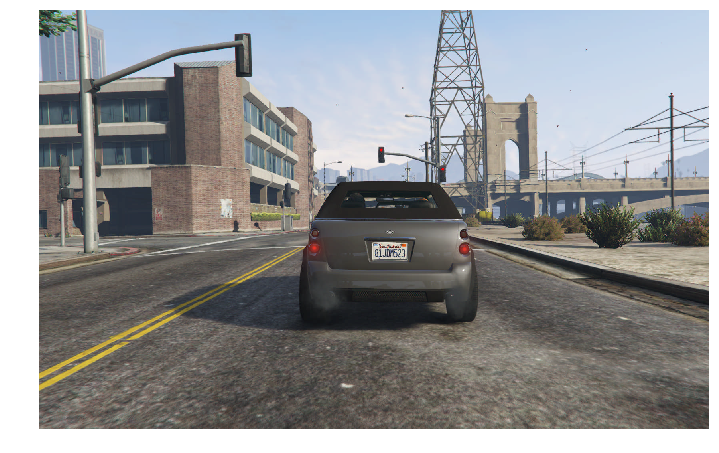

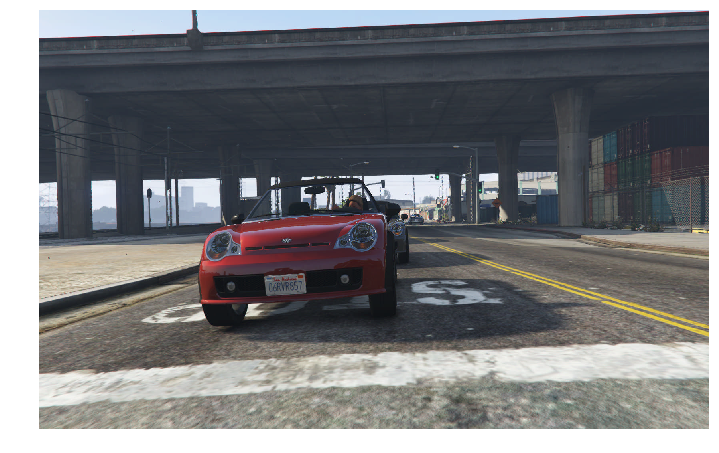

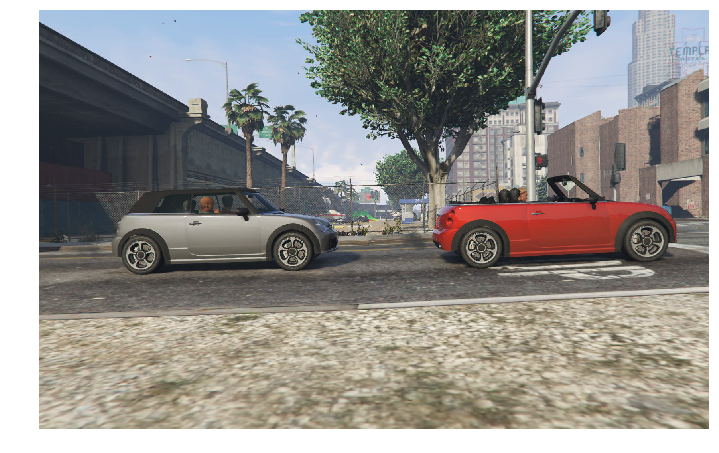

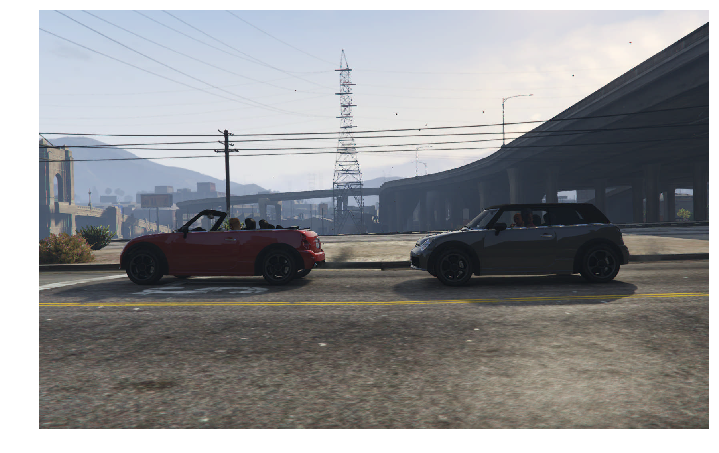

In [13]:
for name in names:
    im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(im)
    plt.show()

### showing depths

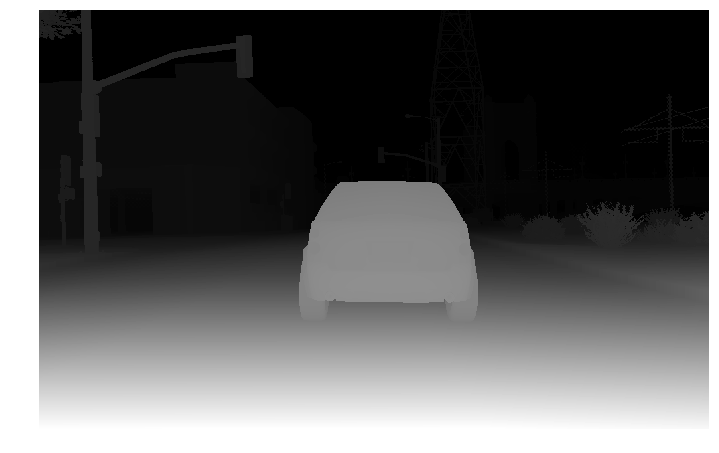

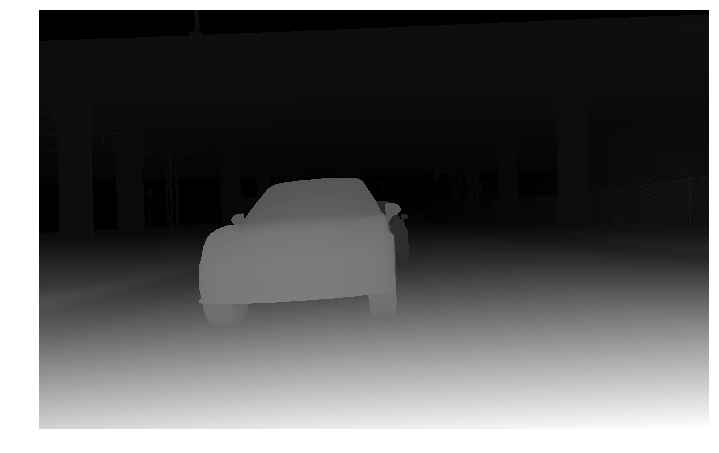

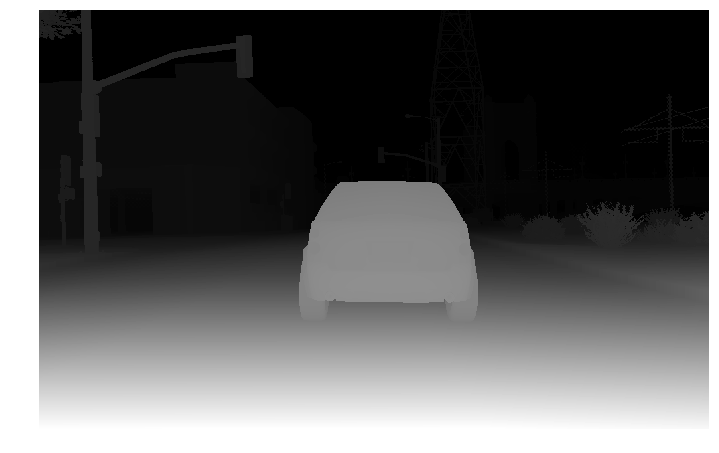

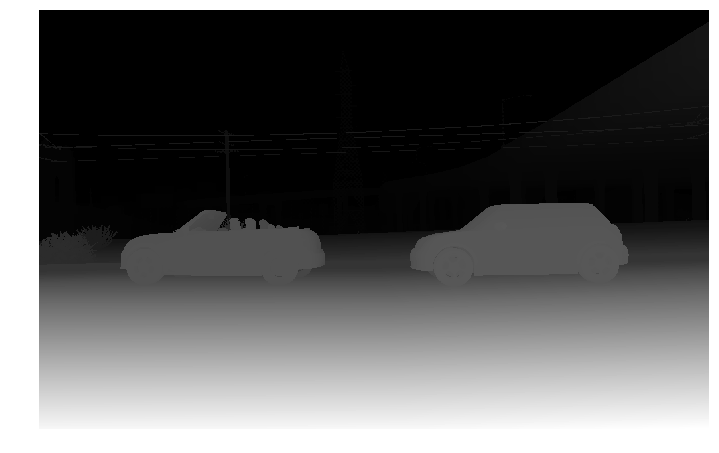

In [15]:
for name in names:
    depth = load_depth(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()


### showing stencil ids

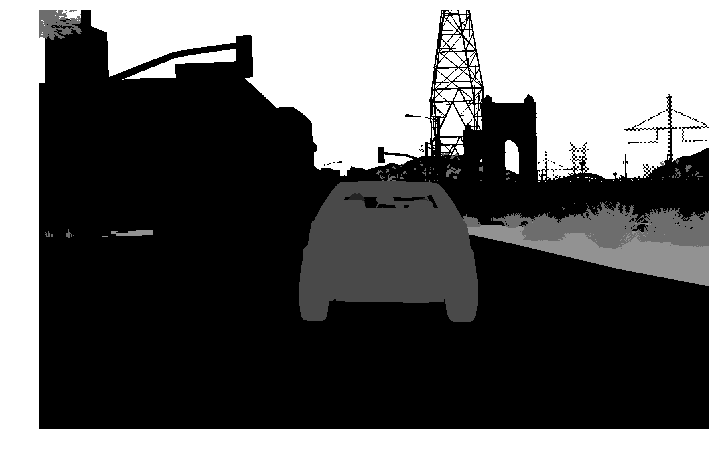

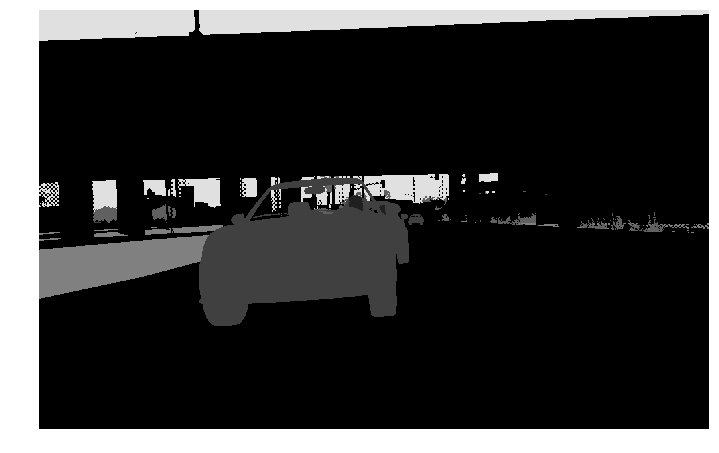

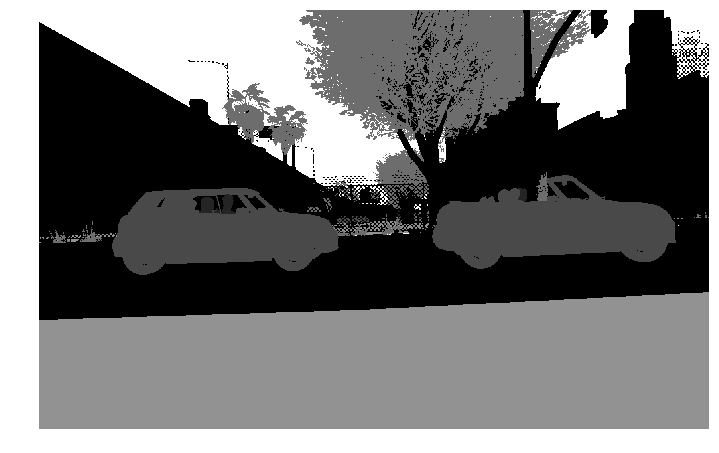

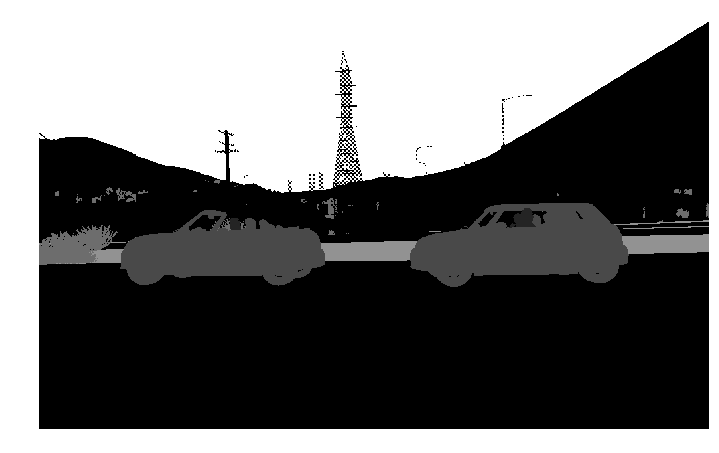

In [14]:
for name in names:
    depth = load_stencil_ids(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()


### tinkering with depth, showing its values

Depth is in NDC, openGL's Normalized Device Coordinates. 

According to [this thread](https://www.opengl.org/discussion_boards/showthread.php/170718-Normalized-Device-Coordinates) 
it maps from $[ near clip (n_c), far clip(f_c)]$ to $[-1, 1]$.

So the formula for calculating NDC from world coordinates (WC) is simple linear transformation:

$ NDC = k \cdot WC + q $

$ -1 = k \cdot n_c + q $

$ 1 = k \cdot f_c + q $

After solving these equations, we obtain transformation parameters

$ q = -1 - k \cdot n_c $

$ q = 1 - k \cdot f_c $

$ -1 - k \cdot n_c = 1 - k \cdot f_c $

$ - k \cdot n_c = 2 - k \cdot f_c $

$ -2 = k (n_c - f_c) $

$ k = \frac{-2}{n_c - f_c} $

$ q = 1 - k \cdot f_c $

$ q = 1 - \frac{-2}{n_c - f_c} \cdot f_c $

$ q = 1 + \frac{2 f_c}{n_c - f_c} $

So the resulting linear transformations is as follows

$ NDC = \frac{-2}{n_c - f_c} \cdot WC + \frac{2 f_c}{n_c - f_c} $

And the reverse transformation, from NDC back to WC, shall be obtained by the same approach

$ WC = k \cdot NDC + q $

$ n_c = k \cdot -1 + q $

$ f_c = k \cdot 1 + q $

$ n_c = -k + q $

$ f_c = k + q $

After solving these equations, we obtain transformation parameters

$ q = n_c + k $

$ q = f_c - k $

$ n_c + k = f_c - k $

$ n_c + 2k = f_c $

$ k = \frac{f_c - n_c}{2} $

$ q = f_c - k $

$ q = f_c - \frac{f_c - n_c}{2} $

$ q = f_c + \frac{-f_c + n_c}{2} $

$ q = \frac{f_c + n_c}{2} $

And resulting transformation is

$ WC = \frac{f_c - n_c}{2} \cdot NDC + \frac{f_c + n_c}{2} $


In [ ]:
for res in results:    
    name = res['imagepath']
    depth = load_depth(name)
    near_clip = res['cam_near_clip']
    far_clip = res['cam_far_clip']
    print('camera rot: {}'.format(res['relative_cam_rot']))
    print('depth min: {}'.format(np.min(depth)))
    print('depth max: {}'.format(np.max(depth)))
    print('near clip: {}'.format(near_clip))
    print('far clip: {}'.format(far_clip))
    
    k = (far_clip - near_clip) / 2
    q = (far_clip + near_clip) / 2
    new_depth = depth * k + q
    print('new depth min: {}'.format(np.min(new_depth)))
    print('new depth max: {}'.format(np.max(new_depth)))
    
    # fig = plt.figure(figsize=(12,12))
    # plt.axis('off')
    # plt.imshow(new_depth, cmap='gray')
    # plt.show()
